In [1]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gurobipy import *

In [2]:
NET_SIZE = 12

# FACILITY
CANDIDATES = [(3*x, 3*y) for x in range(5) for y in range(5)]
J = len(CANDIDATES)

# CAR TYPE
K = 2
V = [[random.randint(1, 10) for k in range(K)] for j in range(J)]

# COMPETITORS
COMPETITORS = [(4, 4), (4, 8), (8, 4), (8, 8)]
L = len(COMPETITORS)

A_c = [random.randint(10, 100) for x in range(L)]


# CONSUMERS
I = 3
CONSUMERS = []
while(len(CONSUMERS) != I):
    temp_new_cons = (random.randint(0, NET_SIZE), random.randint(0, NET_SIZE))
    if temp_new_cons not in COMPETITORS and temp_new_cons not in CANDIDATES:
        CONSUMERS.append(temp_new_cons)

ALPHA = [1 for x in range(I)]

H = [random.randint(100, 1000) for x in range(I)]

# DISTANCE
D = []
for x_i, y_i in CONSUMERS:
    temp = []
    for x_j, y_j in CANDIDATES:
        temp.append(((x_i - x_j)**2 + (y_i - y_j)**2)**(1/2))
    D.append(temp)

D_c = []
for x_i, y_i in CONSUMERS:
    temp = []
    for x_l, y_l in COMPETITORS:
        temp.append(((x_i - x_l)**2 + (y_i - y_l)**2)**(1/2))
    D_c.append(temp)

# COST
F = [random.randint(3, 30) for x in range(J)]
C = [random.randint(1, 3) for x in range(J)]
B = [[random.randint(3, 5) for k in range(K)] for j in range(J)]

# BOUND
U_LT = [[random.randint(5, 10) for k in range(K)] for j in range(J)]
U_T = [random.randint(50, 100) for x in range(K)]
U_L = [random.randint(1, 20) for x in range(J)]

A_EX_bound = random.randint(30, 50)

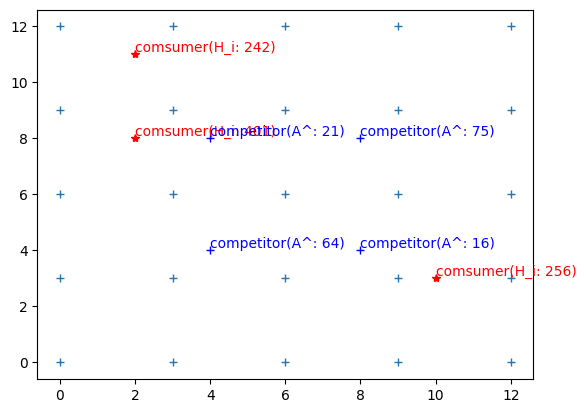

In [3]:
plt.plot([x[0] for x in CONSUMERS], [x[1] for x in CONSUMERS], 'r*')
for i in range(I):
    plt.text(CONSUMERS[i][0], CONSUMERS[i][1]+0.1, 'comsumer(H_i: ' + str(H[i]) + ')', color='r')
plt.plot([x[0] for x in COMPETITORS], [x[1] for x in COMPETITORS], 'b+')
for l in range(L):
    plt.text(COMPETITORS[l][0], COMPETITORS[l][1]+0.1, 'competitor(A^: ' + str(A_c[l]) + ')', color='b')
plt.plot([x[0] for x in CANDIDATES], [x[1] for x in CANDIDATES], '+')
# plt.axis([-1, 13, -1, 13])

In [4]:
def LR_alg_1_noG_withE_reform(lambda_n, mu_n, rho_n, sigma_n):
    
    Y = [-1 for x in range(J)]
    sum_lambda_U_LT_list = []

    for j in range(J):
        
        sum_lambda_U_LT = 0
        for k in range(K):
            sum_lambda_U_LT = sum_lambda_U_LT + lambda_n[j][k]*U_LT[j][k]
        sum_lambda_U_LT_list.append(sum_lambda_U_LT)

        if -F[j] + sum_lambda_U_LT + sigma_n[j]*A_EX_bound >= 0:
            Y[j] = 1
        else:
            Y[j] = 0


    k_star = []
    for j in range(J):
        best_cp = -float('inf')
        best_k = -1
        for k in range(K):
            cp_temp = V[j][k]/(B[j][k] + lambda_n[j][k] + mu_n[j] + rho_n[k])
            if cp_temp > best_cp:
                best_cp = cp_temp
                best_k = k
        k_star.append(best_k)

    # print('k_star', k_star)

    J1 = []
    J2 = []
    for j in range(J):
        # print('j:', j)
        
        if 1/(C[j] + sigma_n[j]) >= V[j][k_star[j]]/(B[j][k_star[j]] + lambda_n[j][k_star[j]] + mu_n[j] + rho_n[k_star[j]]):
            J1.append(j)
            # print(-C[j] - sigma_n[j])
        else:
            J2.append(j)
            # print(-B[j][k_star[j]] - lambda_n[j][k_star[j]] - mu_n[j] - rho_n[k_star[j]])
    

    #GUROBI

    m = Model("LR_alg_1_with_E")

    ## Create variables
    X = {}
    E2 = {}
    for j in J2:
        X[j] = {}
        X[j][k_star[j]] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="X_" + str(j) + '_' + str(k))

        E2[j] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="E2_" + str(j))


    A_EX = {}
    E1 = {}
    for j in J1:
        A_EX[j] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="A^X_" + str(j))
        
        E1[j] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="E1_" + str(j))      

    TA = {}
    for i in range(I):
        TA[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="TA_" + str(i))
    
    W = {}
    for i in range(I):
        W[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="W_" + str(i))


    ## Integrate new variables
    m.update()

    ## Set objective
    m.setObjective(quicksum(W[i] for i in range(I))\
                 + quicksum((-C[j] - sigma_n[j])*A_EX[j] for j in J1) \
                 + quicksum((-B[j][k_star[j]] - lambda_n[j][k_star[j]] - mu_n[j] - rho_n[k_star[j]])*X[j][k_star[j]] for j in J2) \
                 + quicksum(mu_n[j]*U_L[j] for j in range(J)) + quicksum(rho_n[k]*U_T[k] for k in range(K)), GRB.MAXIMIZE)

    ## Add constraints:
    # no constraints

    for j in J1:
        m.addConstr(E1[j] == A_EX[j], 'define_E1_' + str(j))

    for j in J2:
        m.addConstr(E2[j] == V[j][k_star[j]]*X[j][k_star[j]], 'define_E1_' + str(j))

    for i in range(I):
        m.addConstr(TA[i] == quicksum((-0.004*E1[j]**2 + 0.8*E1[j])/D[i][j]**2 for j in J1) + quicksum((-0.004*E2[j]**2 + 0.8*E2[j])/D[i][j]**2 for j in J2) + quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_TA_' + str(i))
        
    for i in range(I):
        m.addConstr(W[i]*TA[i] == H[i]*ALPHA[i]*TA[i] - H[i]*ALPHA[i]*quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_W_' + str(i))

    m.optimize()


    print('\n##################\nObj: %g \n##################\n' % m.objVal)

    print('J1:', J1)
    print('J2:', J2)

    
    print('\nbuild')
    for j in range(J):
        if Y[j] > 0:
            print('Y_' + str(j), Y[j])
    
    print('\ndecoration')
    for j in J1:
        if A_EX[j].x > 0:
            print('A_EX_' + str(j), A_EX[j].x)
    
    print('\nCar')
    for j in J2:
        if X[j][k_star[j]].x > 0:
            print('X' + str(j) + '_' + str(k_star[j]), X[j][k_star[j]].x)


In [5]:
def LR_alg_1_noG_withE_noReform(lambda_n, mu_n, rho_n, sigma_n):
    
    Y = [-1 for x in range(J)]
    sum_lambda_U_LT_list = []

    for j in range(J):
        
        sum_lambda_U_LT = 0
        for k in range(K):
            sum_lambda_U_LT = sum_lambda_U_LT + lambda_n[j][k]*U_LT[j][k]
        sum_lambda_U_LT_list.append(sum_lambda_U_LT)

        if -F[j] + sum_lambda_U_LT + sigma_n[j]*A_EX_bound >= 0:
            Y[j] = 1
        else:
            Y[j] = 0


    k_star = []
    for j in range(J):
        best_cp = -float('inf')
        best_k = -1
        for k in range(K):
            cp_temp = V[j][k]/(B[j][k] + lambda_n[j][k] + mu_n[j] + rho_n[k])
            if cp_temp > best_cp:
                best_cp = cp_temp
                best_k = k
        k_star.append(best_k)

    # print('k_star', k_star)

    J1 = []
    J2 = []
    for j in range(J):
        # print('j:', j)
        
        if 1/(C[j] + sigma_n[j]) >= V[j][k_star[j]]/(B[j][k_star[j]] + lambda_n[j][k_star[j]] + mu_n[j] + rho_n[k_star[j]]):
            J1.append(j)
            # print(-C[j] - sigma_n[j])
        else:
            J2.append(j)
            # print(-B[j][k_star[j]] - lambda_n[j][k_star[j]] - mu_n[j] - rho_n[k_star[j]])
    

    #GUROBI

    m = Model("LR_alg_1_with_E")

    ## Create variables
    X = {}
    E2 = {}
    for j in J2:
        X[j] = {}
        X[j][k_star[j]] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="X_" + str(j) + '_' + str(k))

        E2[j] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="E2_" + str(j))


    A_EX = {}
    E1 = {}
    for j in J1:
        A_EX[j] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="A^X_" + str(j))
        
        E1[j] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="E1_" + str(j))      

    TA = {}
    for i in range(I):
        TA[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="TA_" + str(i))
    
    W = {}
    for i in range(I):
        W[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="W_" + str(i))


    ## Integrate new variables
    m.update()

    ## Set objective
    m.setObjective(quicksum(W[i] for i in range(I))\
                 + quicksum((-C[j] - sigma_n[j])*A_EX[j] for j in J1) \
                 + quicksum((-B[j][k_star[j]] - lambda_n[j][k_star[j]] - mu_n[j] - rho_n[k_star[j]])*X[j][k_star[j]] for j in J2) \
                 + quicksum(mu_n[j]*U_L[j] for j in range(J)) + quicksum(rho_n[k]*U_T[k] for k in range(K)), GRB.MAXIMIZE)

    ## Add constraints:
    # no constraints

    for j in J1:
        m.addConstr(E1[j] == A_EX[j], 'define_E1_' + str(j))

    for j in J2:
        m.addConstr(E2[j] == V[j][k_star[j]]*X[j][k_star[j]], 'define_E1_' + str(j))

    for i in range(I):
        m.addConstr(TA[i] == quicksum((-0.004*E1[j]**2 + 0.8*E1[j])/D[i][j]**2 for j in J1) + quicksum((-0.004*E2[j]**2 + 0.8*E2[j])/D[i][j]**2 for j in J2) + quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_TA_' + str(i))
        
    for i in range(I):
        m.addConstr(W[i]*TA[i] == H[i]*ALPHA[i]*(quicksum((-0.004*E1[j]**2 + 0.8*E1[j])/D[i][j]**2 for j in J1) + quicksum((-0.004*E2[j]**2 + 0.8*E2[j])/D[i][j]**2 for j in J2)), 'define_W_' + str(i))

    m.optimize()


    print('\n##################\nObj: %g \n##################\n' % m.objVal)

    print('J1:', J1)
    print('J2:', J2)

    
    print('\nbuild')
    for j in range(J):
        if Y[j] > 0:
            print('Y_' + str(j), Y[j])
    
    print('\ndecoration')
    for j in J1:
        if A_EX[j].x > 0:
            print('A_EX_' + str(j), A_EX[j].x)
    
    print('\nCar')
    for j in J2:
        if X[j][k_star[j]].x > 0:
            print('X' + str(j) + '_' + str(k_star[j]), X[j][k_star[j]].x)


In [12]:
def original_noG_withE_reform():    

    #GUROBI
    m = Model("original_no_G")

    ## Create variables
    X = []
    for j in range(J):
        temp = []
        for k in range(K):
            temp.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="X_" + str(j) + '_' + str(k)))
        X.append(temp)

    A_EX = []
    for j in range(J):
        A_EX.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="A^X_" + str(j)))

    Y = []
    for j in range(J):
        Y.append(m.addVar(vtype=GRB.BINARY, lb=0, name="Y_" + str(j)))

    E_var = []
    for j in range(J):
        E_var.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="E_var_" + str(j)))

    TA = {}
    for i in range(I):
        TA[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="TA_" + str(i))

    W = {}
    for i in range(I):
        W[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="W_" + str(i))


    ## Integrate new variables
    m.update()

    ## Set objective
    m.setObjective(quicksum(W[i] for i in range(I)) \
                 - quicksum(F[j]*Y[j] + C[j]*A_EX[j] + quicksum(B[j][k]*X[j][k] for k in range(K))  for j in range(J)) , GRB.MAXIMIZE)


    ## Add constraints:

    for j in range(J):
        m.addConstr(E_var[j] == quicksum(V[j][k]*X[j][k] for k in range(K)) + A_EX[j], 'define_E_var_' + str(j))

    for i in range(I):
        m.addConstr(TA[i] == quicksum((-0.004*E_var[j]**2 + 0.8*E_var[j])/D[i][j]**2 for j in range(J)) + quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_TA_' + str(i))

    for i in range(I):
        m.addConstr(W[i]*TA[i] == H[i]*ALPHA[i]*TA[i] - H[i]*ALPHA[i]*quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_W_' + str(i))

    for j in range(J):
        for k in range(K):
            m.addConstr(X[j][k] <= U_LT[j][k]*Y[j], 'build_to_allocate_' + str(j) + '_' + str(k))

    for k in range(K):
        m.addConstr(quicksum(X[j][k] for j in range(J)) <= U_T[k], 'car_amount_limit_' + str(k))
    
    for j in range(J):
        m.addConstr(quicksum(X[j][k] for k in range(K)) <= U_L[j], 'facility_limit_' + str(j))

    for j in range(J):
        m.addConstr(A_EX[j] <= A_EX_bound*Y[j], 'decoration_limit_' + str(j))

    m.optimize()


    print('\n##################\nObj: %g \n##################\n' % m.objVal)

    

    print('build')
    built_candidates =[]
    built_candidates_id =[]
    for j in range(J):
        if Y[j].x > 0:
            built_candidates.append(CANDIDATES[j])
            built_candidates_id.append(j)
            print('Y_' + str(j), Y[j].x)

    print('\ndecoration')
    for j in range(J):
        if A_EX[j].x > 0:
            print('A_EX_' + str(j), A_EX[j].x)
    
    print('\nCar')
    for j in range(J):
        for k in range(K):
            if X[j][k].x > 0:
                print('X' + str(j) + '_' + str(k), X[j][k].x)



    plt.plot([x[0] for x in CONSUMERS], [x[1] for x in CONSUMERS], 'r*')
    for i in range(I):
        plt.text(CONSUMERS[i][0], CONSUMERS[i][1]+0.1, 'comsumer(H_i: ' + str(H[i]) + ')', color='r')
    plt.plot([x[0] for x in COMPETITORS], [x[1] for x in COMPETITORS], 'b+')
    for l in range(L):
        plt.text(COMPETITORS[l][0], COMPETITORS[l][1]+0.1, 'competitor(A^: ' + str(A_c[l]) + ')', color='b')

    plt.plot([x[0] for x in built_candidates], [x[1] for x in built_candidates], '+', color='orange')
    for j in range(len(built_candidates)):
        plt.text(built_candidates[j][0], built_candidates[j][1]+0.1, 'No.' + str(built_candidates_id[j]) + ': ' +  str(E_var[built_candidates_id[j]].x), color='orange')



In [25]:
def original_withG_withE_reform():    

    #GUROBI
    m = Model("original_no_G")

    ## Create variables
    X = []
    for j in range(J):
        temp = []
        for k in range(K):
            temp.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="X_" + str(j) + '_' + str(k)))
        X.append(temp)

    A_EX = []
    for j in range(J):
        A_EX.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="A^X_" + str(j)))

    Y = []
    for j in range(J):
        Y.append(m.addVar(vtype=GRB.BINARY, lb=0, name="Y_" + str(j)))

    E_var = []
    for j in range(J):
        E_var.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="E_var_" + str(j)))

    G_var = []
    for i in range(I):
        G_var.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub= 1, name="G_var_" + str(i)))

    TA = {}
    for i in range(I):
        TA[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="TA_" + str(i))

    W = {}
    for i in range(I):
        W[i] = m.addVar(vtype=GRB.CONTINUOUS, lb=0, name="W_" + str(i))


    ## Integrate new variables
    m.update()

    ## Set objective
    m.setObjective(quicksum(W[i] for i in range(I)) \
                 - quicksum(F[j]*Y[j] + C[j]*A_EX[j] + quicksum(B[j][k]*X[j][k] for k in range(K))  for j in range(J)) , GRB.MAXIMIZE)


    ## Add constraints:

    for j in range(J):
        m.addConstr(E_var[j] == quicksum(V[j][k]*X[j][k] for k in range(K)) + A_EX[j], 'define_E_var_' + str(j))

    for i in range(I):
        m.addConstr(G_var[i] <= -0.000015*TA[i]**2 + 0.0095*TA[i], 'define_G_var_' + str(i))

    for i in range(I):
        m.addConstr(TA[i] == quicksum((-0.004*E_var[j]**2 + 0.8*E_var[j])/D[i][j]**2 for j in range(J)) + quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_TA_' + str(i))

    for i in range(I):
        m.addConstr(W[i]*TA[i] == H[i]*G_var[i]*TA[i] - H[i]*ALPHA[i]*quicksum(A_c[l]/D_c[i][l]**2 for l in range(L)), 'define_W_' + str(i))

    for j in range(J):
        for k in range(K):
            m.addConstr(X[j][k] <= U_LT[j][k]*Y[j], 'build_to_allocate_' + str(j) + '_' + str(k))

    for k in range(K):
        m.addConstr(quicksum(X[j][k] for j in range(J)) <= U_T[k], 'car_amount_limit_' + str(k))
    
    for j in range(J):
        m.addConstr(quicksum(X[j][k] for k in range(K)) <= U_L[j], 'facility_limit_' + str(j))

    for j in range(J):
        m.addConstr(A_EX[j] <= A_EX_bound*Y[j], 'decoration_limit_' + str(j))

    m.optimize()


    print('\n##################\nObj: %g \n##################\n' % m.objVal)

    

    print('build')
    built_candidates =[]
    built_candidates_id =[]
    for j in range(J):
        if Y[j].x > 0:
            built_candidates.append(CANDIDATES[j])
            built_candidates_id.append(j)
            print('Y_' + str(j), Y[j].x)

    print('\ndecoration')
    for j in range(J):
        if A_EX[j].x > 0:
            print('A_EX_' + str(j), A_EX[j].x)
    
    print('\nCar')
    for j in range(J):
        for k in range(K):
            if X[j][k].x > 0:
                print('X' + str(j) + '_' + str(k), X[j][k].x)

    print('\nG')
    for i in range(I):
        print('G_var_' + str(i) + ':', G_var[i].x)

    print('\nTA')
    for i in range(I):
        print('TA_' + str(i) + ':', TA[i].x)



    plt.plot([x[0] for x in CONSUMERS], [x[1] for x in CONSUMERS], 'r*')
    for i in range(I):
        plt.text(CONSUMERS[i][0], CONSUMERS[i][1]+0.1, 'comsumer(H_i: ' + str(H[i]) + ')', color='r')
    plt.plot([x[0] for x in COMPETITORS], [x[1] for x in COMPETITORS], 'b+')
    for l in range(L):
        plt.text(COMPETITORS[l][0], COMPETITORS[l][1]+0.1, 'competitor(A^: ' + str(A_c[l]) + ')', color='b')

    plt.plot([x[0] for x in built_candidates], [x[1] for x in built_candidates], '+', color='orange')
    for j in range(len(built_candidates)):
        plt.text(built_candidates[j][0], built_candidates[j][1]+0.1, 'No.' + str(built_candidates_id[j]) + ': ' +  str(E_var[built_candidates_id[j]].x), color='orange')



In [13]:
lambda_list = [[[1 for k in range(K)] for j in range(J)]]
mu_list = [[1 for j in range(J)]]
rho_list = [[1 for k in range(K)]]
sigma_list = [[1 for j in range(J)]]


In [7]:
LR_alg_1_noG_withE_reform(lambda_list[0], mu_list[0], rho_list[0], sigma_list[0])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-19
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 25 rows, 56 columns and 50 nonzeros
Model fingerprint: 0x7e9d116b
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  QMatrix range    [2e-05, 1e+00]
  QLMatrix range   [4e-03, 4e+02]
  Objective range  [1e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [5e+00, 4e+03]
Presolve removed 25 rows and 25 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 25 rows and 25 columns
Presolve time: 0.00s
Presolved: 90 rows, 57 columns, 290 nonzeros
Presolved model has 28 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for th

In [8]:
LR_alg_1_noG_withE_noReform(lambda_list[0], mu_list[0], rho_list[0], sigma_list[0])

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 25 rows, 56 columns and 50 nonzeros
Model fingerprint: 0xe9101251
Model has 6 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  QMatrix range    [2e-05, 1e+00]
  QLMatrix range   [4e-03, 2e+02]
  Objective range  [1e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [5e+00, 1e+01]
Presolve removed 25 rows and 25 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 25 rows and 25 columns
Presolve time: 0.00s
Presolved: 93 rows, 60 columns, 452 nonzeros
Presolved model has 28 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for these variables.
         Consider bounding these variables or reformulating the model.

Vari

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 127 rows, 131 columns and 350 nonzeros
Model fingerprint: 0x7dfccca9
Model has 6 quadratic constraints
Variable types: 106 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  QMatrix range    [2e-05, 1e+00]
  QLMatrix range   [4e-03, 4e+02]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [5e+00, 4e+03]
Presolve removed 26 rows and 0 columns
Presolve time: 0.00s
Presolved: 191 rows, 157 columns, 612 nonzeros
Presolved model has 28 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for these variables.
         Consider bounding these variables or reformulating the model.


Solving non-convex MIQCP

Variable ty

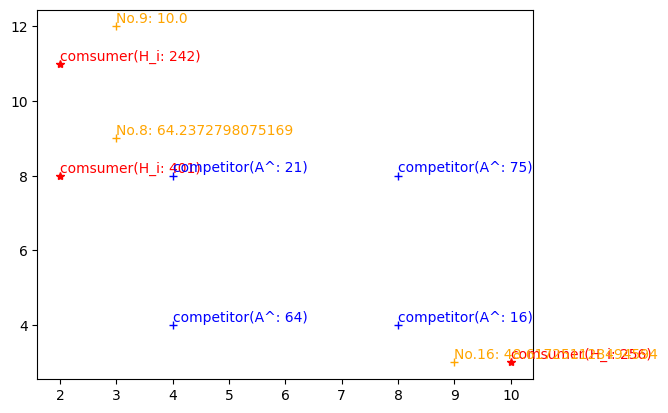

In [14]:
original_noG_withE_reform()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.0.0 23A344)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 127 rows, 134 columns and 350 nonzeros
Model fingerprint: 0xb858b390
Model has 9 quadratic constraints
Variable types: 109 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  QMatrix range    [2e-05, 4e+02]
  QLMatrix range   [4e-03, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+01]
  QRHS range       [5e+00, 4e+03]
Presolve removed 26 rows and 0 columns
Presolve time: 0.00s
Presolved: 209 rows, 168 columns, 678 nonzeros
Presolved model has 3 quadratic constraint(s)
Presolved model has 31 bilinear constraint(s)

Solving non-convex MIQCP

Variable types: 143 continuous, 25 integer (25 binary)

Root relaxation: objective 4.819364e+03, 142 iterations, 0.00 seconds (0.00 work units

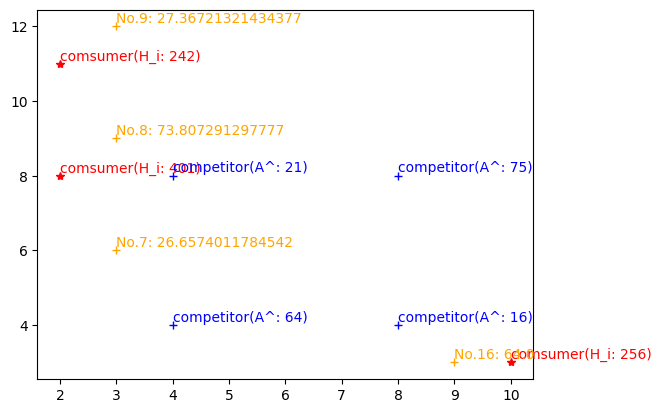

In [26]:
original_withG_withE_reform()

In [15]:
print('V:', V)
print('F:', F)
print('C:', C)
print('B:', B)
print('U_LT:', U_LT)
print('U_T:', U_T)
print('U_L:', U_L)
print('A_EX_bound:', A_EX_bound)


V: [[3, 6], [1, 4], [4, 3], [4, 4], [1, 3], [9, 7], [9, 4], [1, 4], [9, 5], [5, 10], [6, 2], [3, 8], [5, 1], [9, 8], [5, 8], [5, 2], [2, 8], [8, 5], [2, 3], [6, 9], [7, 9], [1, 10], [6, 5], [3, 9], [9, 6]]
F: [29, 16, 7, 28, 23, 30, 28, 10, 19, 8, 17, 28, 14, 27, 12, 22, 3, 25, 12, 11, 29, 28, 17, 6, 8]
C: [1, 3, 2, 3, 3, 3, 2, 2, 1, 2, 1, 2, 3, 2, 1, 2, 2, 1, 2, 3, 3, 2, 3, 1, 3]
B: [[5, 4], [5, 3], [3, 5], [4, 4], [4, 4], [4, 3], [3, 3], [3, 4], [4, 3], [4, 5], [4, 3], [5, 3], [3, 4], [5, 3], [4, 3], [3, 5], [5, 5], [3, 3], [4, 5], [5, 5], [3, 5], [3, 5], [4, 4], [5, 3], [4, 4]]
U_LT: [[7, 6], [10, 9], [8, 7], [8, 9], [5, 5], [6, 10], [6, 7], [10, 10], [5, 6], [5, 7], [10, 8], [10, 5], [5, 5], [6, 10], [8, 9], [8, 5], [9, 8], [5, 7], [9, 5], [9, 7], [7, 6], [8, 5], [9, 7], [10, 10], [8, 8]]
U_T: [72, 62]
U_L: [10, 14, 5, 1, 5, 2, 4, 17, 4, 1, 10, 11, 14, 8, 1, 12, 9, 11, 14, 20, 1, 20, 9, 17, 13]
A_EX_bound: 48


In [ ]:
# V: [[8, 8], [6, 6], [4, 2], [6, 1], [6, 1], [8, 3], [10, 6], [5, 8], [9, 1], [1, 3], [6, 3], [4, 10], [3, 3], [3, 9], [4, 6], [7, 3], [4, 1], [10, 6], [10, 1], [3, 8], [3, 7], [7, 9], [4, 4], [8, 5], [10, 8]]
# F: [12, 19, 3, 12, 8, 16, 13, 30, 23, 18, 23, 19, 21, 18, 5, 21, 7, 27, 21, 17, 26, 3, 4, 10, 14]
# C: [1, 1, 1, 2, 3, 1, 1, 1, 2, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 1, 1, 2, 1, 3]
# B: [[4, 3], [5, 4], [5, 3], [4, 3], [3, 5], [3, 3], [4, 4], [3, 4], [4, 5], [5, 3], [5, 3], [5, 5], [5, 4], [3, 5], [5, 3], [3, 3], [3, 5], [3, 3], [3, 3], [4, 3], [4, 3], [4, 5], [4, 4], [4, 3], [4, 4]]
# U_LT: [[8, 5], [6, 5], [6, 6], [10, 6], [7, 6], [6, 10], [9, 7], [10, 5], [10, 6], [10, 6], [6, 5], [8, 7], [9, 7], [8, 5], [8, 10], [9, 8], [7, 9], [10, 6], [10, 7], [7, 10], [5, 6], [7, 6], [8, 6], [6, 6], [7, 6]]
# U_T: [58, 95]
# U_L: [20, 9, 3, 13, 12, 18, 9, 10, 12, 19, 3, 14, 11, 8, 7, 14, 15, 8, 13, 18, 18, 17, 15, 6, 9]
# A_EX_bound: 38